<a href="https://colab.research.google.com/github/Samarth1410/ML-Projects/blob/main/PyTorch%20CNN%20-%20MNIST%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN Project: Image generation using convolutional GANs  



## Description

In this project, I will generate MNIST digits using GAN framework and CNNs. We will be using the architecture of DCGAN.


## Initialize and data handling

Lets import some libraries and get the data we will work with.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(0)
np.random.seed(0)

cuda:0


Set the batch size to 32 for train and 1 for test. Resize the images to 64 $\times$ 64 because DCGAN is optimized for those dimensions.

In [2]:
batch_size_train = 32
batch_size_test  = 1

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

train_data   = torchvision.datasets.MNIST(root='/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

train_data   = torchvision.datasets.MNIST(root='/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

test_data    = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)  
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw



Initialize some parameters to be used in our code later.

In [3]:
# Number of channels in the training images. For MNIST data it is 1
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 16 

# Size of feature maps in generator
ngf = 8

# Size of feature maps in discriminator
ndf = 8

# Number of epochs
N_epochs = 10

# fixed latent vector to see how our output changes for these vectors during training
fixed_latent = torch.randn(16, nz, 1, 1).to(device)

## Network

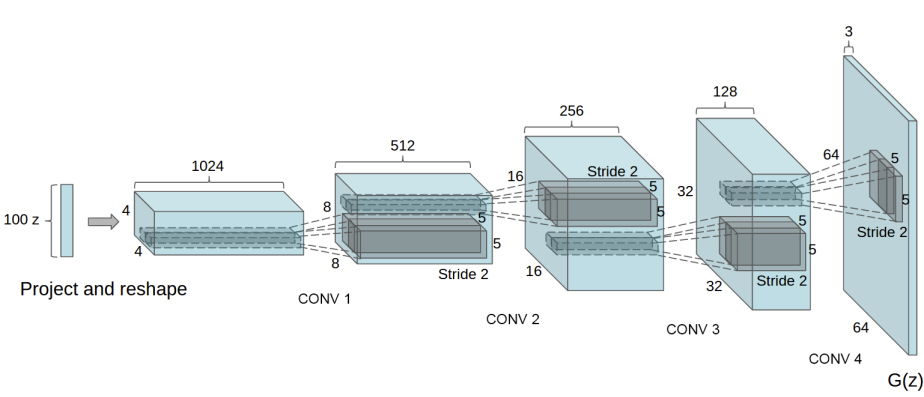

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( (ngf*8), ngf * 4, 4, 2, 1, bias=False),  #TODO
            nn.BatchNorm2d(ngf * 4),                                                            #nc =1 , nz = 16, ngf =8, ndf = 8, 
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf*4, ngf * 2, 4, 2, 1, bias=False),  #TODO
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf*2, ngf, 4, 2, 1, bias=False),  #TODO
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),

        )

    def forward(self, input):
      return self.main(input)
    
generator = Generator().to(device)

The discriminator is just the opposite of the generator in architecture. I am trying to compare the two.

The target of the discriminator is to take in an image and predict whether it comes from the dataset or the generator. It outputs 1 if it thinks it comes from the dataset and 0 if it thinks it comes from the generator.

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    
discriminator = Discriminator().to(device)

Defining the optimizer below.

In [14]:
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) 

The loss function is given below.

The generator loss `criterion_g` tries to maximize it probability of fooling the discriminator.

Whereas the discriminator loss `criterion_d` tries to maximize the probability of catching the fakes produced by the generator.

`p` here denotes probability given by the disciminator.

In [15]:
def criterion_g(p_fake):
    return -torch.mean(torch.log(p_fake))

def criterion_d(p_real, p_fake):
    return -torch.mean(torch.log(p_real) + torch.log(1-p_fake))

## Training

The helper function below will plot the images produced by the generator as we proceed with the training.

In [16]:
def show_image_grid(images):
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    plt.subplots_adjust(wspace=0.0, hspace=0.1)
    plt.show()

The training loop is given below.

We alternate the training of the discriminator and the generator. The generator produced some images and discriminator tries to distinguish between the reals and the fakes.

At the end of each epoch, we plot the images corresponding to the fixed latent defined above.

Epoch    0 | Train Loss g   3.5353 | Train Loss d   0.2165


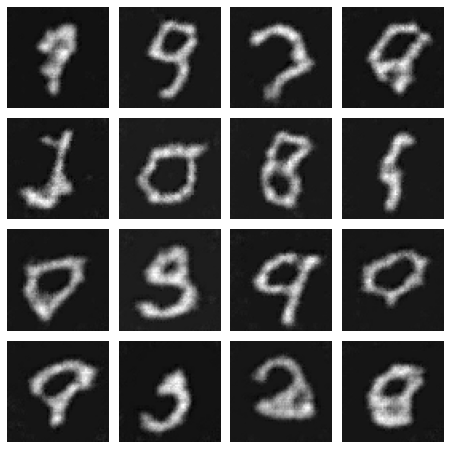

Epoch    1 | Train Loss g   2.6553 | Train Loss d   0.3827


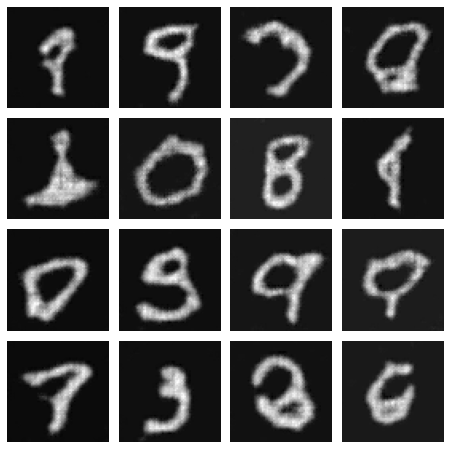

Epoch    2 | Train Loss g   2.4563 | Train Loss d   0.4277


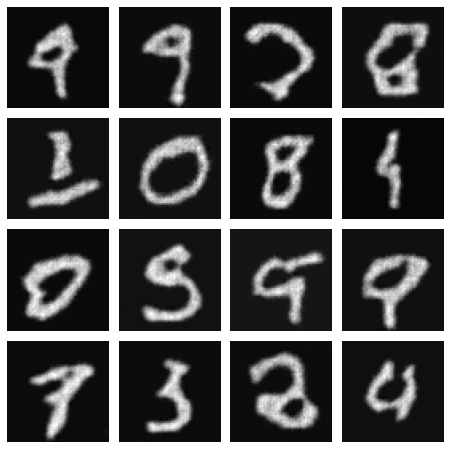

Epoch    3 | Train Loss g   2.5127 | Train Loss d   0.4186


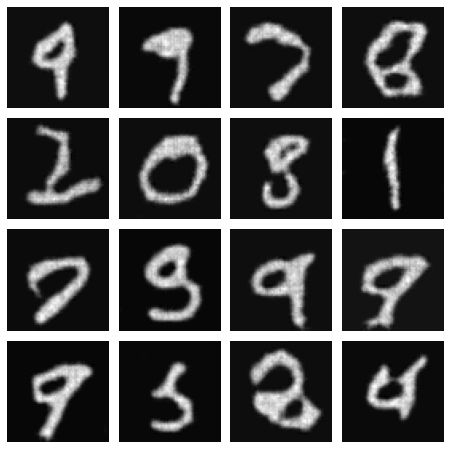

Epoch    4 | Train Loss g   2.8384 | Train Loss d   0.3498


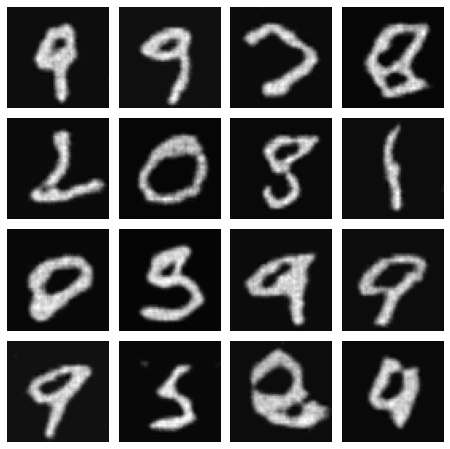

Epoch    5 | Train Loss g   3.1069 | Train Loss d   0.2876


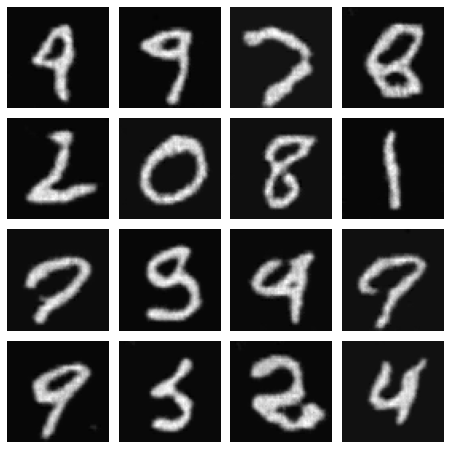

Epoch    6 | Train Loss g   3.3458 | Train Loss d   0.2753


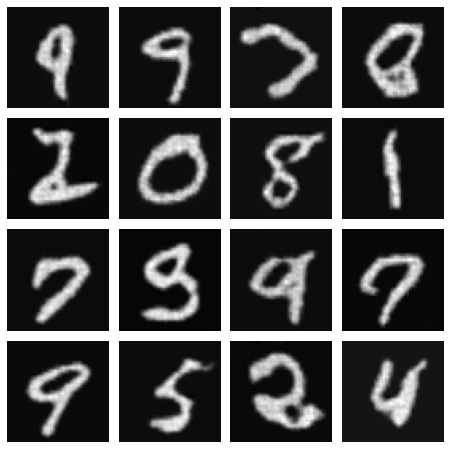

Epoch    7 | Train Loss g   3.5549 | Train Loss d   0.2257


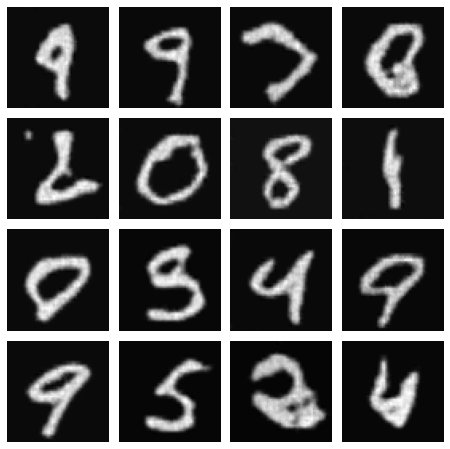

Epoch    8 | Train Loss g   3.8208 | Train Loss d   0.2242


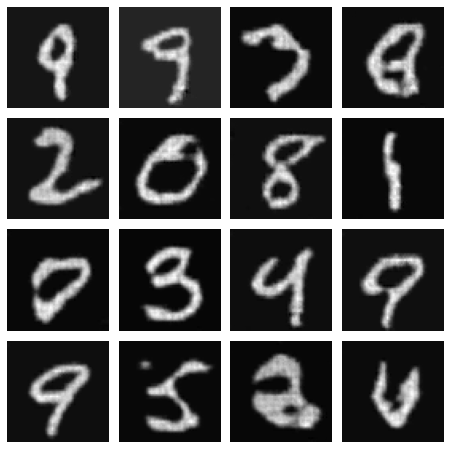

Epoch    9 | Train Loss g   4.1412 | Train Loss d   0.1972


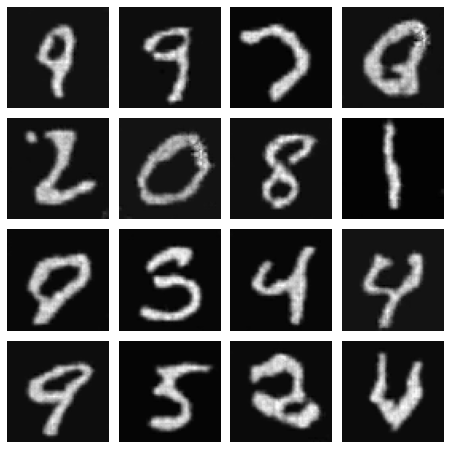

In [17]:
train_losses_g_epoch = []
train_losses_d_epoch = []
fixed_latent_outputs = []

for epoch in range(N_epochs):
    train_losses_g = []
    train_losses_d = []

    generator.train()
    discriminator.train()
    for batch_idx, (images, _) in enumerate(train_loader):
        real = images.to(device)
        latent = torch.randn(batch_size_train, nz, 1, 1).to(device)
        fake = generator(latent)
        
        p_real = discriminator(real)
        p_fake = discriminator(fake) 
        loss_d = criterion_d(p_real, p_fake)        
        optimizer_d.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        p_fake = discriminator(fake)
        loss_g = criterion_g(p_fake)
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        train_losses_g.append(loss_g.item())
        train_losses_d.append(loss_d.item())
    
    generator.eval()
    with torch.no_grad():
        fixed_latent_output = generator(fixed_latent)
        fixed_latent_output = fixed_latent_output.cpu().detach().numpy().reshape(-1,64,64)
        fixed_latent_outputs.append(fixed_latent_output)
    
    train_losses_g_epoch.append(sum(train_losses_g) / len(train_losses_g))
    train_losses_d_epoch.append(sum(train_losses_d) / len(train_losses_d))
    
    print('Epoch %4d | Train Loss g %8.4f | Train Loss d %8.4f' %
          (epoch, train_losses_g_epoch[-1], train_losses_d_epoch[-1]))
    
    show_image_grid(fixed_latent_output)

The loss curves are plotted below.



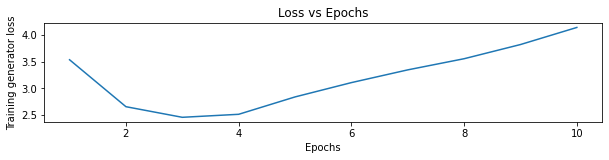

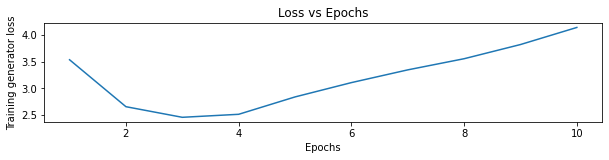

In [18]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(2,1, 1)
ax.plot(np.arange(1,len(train_losses_g_epoch)+1),train_losses_g_epoch)
plt.ylabel('Training generator loss')
plt.xlabel('Epochs')
ax.set_title('Loss vs Epochs')
plt.show()

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(2,1, 2)
ax.plot(np.arange(1,len(train_losses_g_epoch)+1),train_losses_g_epoch)
plt.ylabel('Training generator loss')
plt.xlabel('Epochs')
ax.set_title('Loss vs Epochs')
plt.show()